<a href="https://colab.research.google.com/github/andrew-na-git/Stable-Diffusion/blob/William_branch/Efficient_Diffusion_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diffusion models Testing

In this document we test and build diffusion models and its variations

# Solving the KFP equation

We present classical methods to solve the KFP forward equation

In [1]:
## We start with standard diffusion model denoising diffusion probability model
## we first start by loading the required packages
import torch
import functools
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn as nn
import tqdm
import matplotlib.pyplot as plt

import scipy as sp
from scipy.sparse import coo_array
from scipy import integrate

import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
# download mnist dataset
mnist = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)

mnist_data = np.moveaxis(mnist.data.numpy(), 0, -1)
mnist_data.shape

(28, 28, 60000)

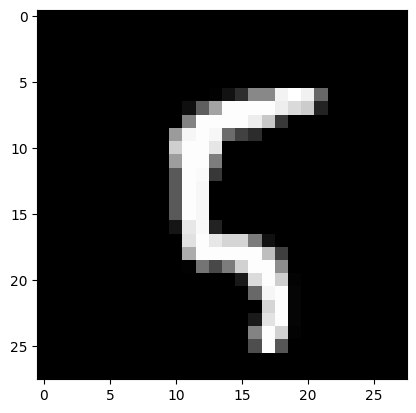

In [3]:
# look at one of the images

plt.imshow(mnist_data[:, :, 100], cmap="gray")

In [4]:
## we construct coefficient matrix and constant matrix
def construct_A(dx,dy,dt,f,g,s,H,W):
  A = np.zeros_like(g)
  for i in range(H):
    for j in range(W):
      if i == 0 and j == 0:
        a = 1/dt + f[i][j]/dx + f[i][j]/dy - 0.5*((g[i][j]**2)*s[i][j])/dx - 0.5*((g[i][j]**2)*s[i][j])/dy
        A[i][j] = a
      elif i == j and i > 0 and j > 0:
        a = 1/dt + f[i][j]/dx + f[i][j]/dy - 0.5*((g[i][j]**2)*s[i][j])/dx - 0.5*((g[i][j]**2)*s[i][j])/dy
        b = -f[i][j-1]/dy + 0.5*((g[i][j-1]**2)*s[i][j-1])/dy
        c = -f[i-1][j]/dx + 0.5*((g[i-1][j]**2)*s[i-1][j])/dx
        A[i][j] = a
        A[i][j-1] = b
        A[i-1][j] = c

  return A

def construct_B(dx,dy,dt,f,g,m_prev,del_sx,del_sy,H,W):
  B = m_prev/dt
  for i in range(H):
    for j in range(W):
      if i > 0 and j > 0 and i == j:
        B[i][j] -= f[i][j]/dx - f[i-1][j]/dx + f[i][j]/dy - f[i][j-1]/dy - 0.5*g[i][j]**2*del_sx[i][j] - 0.5*g[i][j]**2*del_sy[i][j]

  return B

def solve_pde(A,b):
  return sp.linalg.solve(A, b)

In [5]:
## construct the grid and Initial values
# N = mnist_data.data.shape[2] // 32
N = 100
H = mnist_data.data.shape[0]
W = mnist_data.data.shape[1]

x = mnist_data.astype(np.float64)[:, :, :N]

# x = np.zeros((H,W,N))
# for n in range(N):
#   x[:,:,n] = np.random.randint(0,255,(H,W))

t = np.linspace(0,1,N)

dx = 1/H
dy = 1/W
dt = 1/N

sigma = 0.5

f = np.zeros((H,W,N))
g = np.zeros_like(f)
m = np.zeros_like(f)
s = np.zeros_like(g)
del_sx = np.zeros_like(g)
del_sy = np.zeros_like(g)

scaler = MinMaxScaler()

for n in range(N):
  f[:, :, n] = 250
  g[:,:,n] = sigma**(n*dt)
  x[:,:,n] = scaler.fit_transform(x[:,:,n])

## we fit the image onto a gaussian kernel
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:,:,0].ravel()[:, None])

## obtain initial log probability
m[:,:,0] = kde.score_samples(x[:,:,0].ravel()[:, None]).reshape((H,W))
del_m = np.diff(m[:,:,0].ravel())
del_m = np.insert(del_m,0,0)

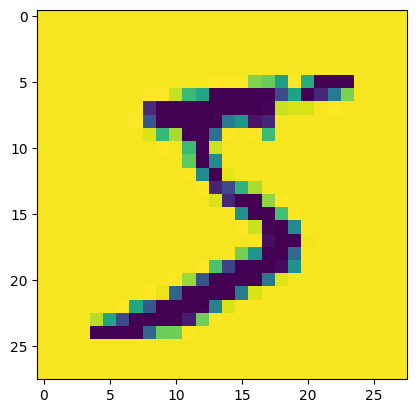

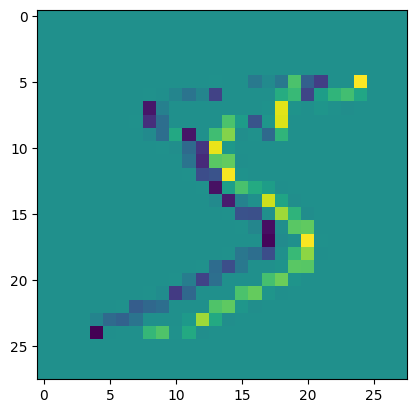

In [6]:
plt.imshow(m[:,:,0]) # this shows the initial log probability
plt.show()

plt.imshow(del_m.reshape(28, 28)) # so we can see that the score should look something like this after training
plt.show()

In [7]:
# create the convolutional network

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights during initialization. These weights are fixed
    # during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    x_proj = x * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class Net(nn.Module):
  def __init__(self, embed_dim=256):
    super().__init__()
    
    channels=[32, 64, 128, 256]
    
    self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
         nn.Linear(embed_dim, embed_dim))
    
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.dense1 = nn.Linear(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.dense2 = nn.Linear(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.dense3 = nn.Linear(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.dense4 = nn.Linear(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.dense5 = nn.Linear(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.dense6 = nn.Linear(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.dense7 = nn.Linear(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)
    
    self.swish = lambda x: x * torch.sigmoid(x)
    
  def forward(self, x, t):
    
    embed = self.swish(self.embed(t))[...]
    
    # Encoding path
    h1 = self.conv1(x)
    ## Incorporate information from t
    h1 += self.dense1(embed)[..., None, None]
    ## Group normalization
    h1 = self.gnorm1(h1)
    h1 = self.swish(h1)
    h2 = self.conv2(h1)
    h2 += self.dense2(embed)[..., None, None]
    h2 = self.gnorm2(h2)
    h2 = self.swish(h2)
    h3 = self.conv3(h2)
    h3 += self.dense3(embed)[..., None, None]
    h3 = self.gnorm3(h3)
    h3 = self.swish(h3)
    h4 = self.conv4(h3)
    h4 += self.dense4(embed)[..., None, None]
    h4 = self.gnorm4(h4)
    h4 = self.swish(h4)

    # Decoding path
    h = self.tconv4(h4)
    ## Skip connection from the encoding path
    h += self.dense5(embed)[..., None, None]
    h = self.tgnorm4(h)
    h = self.swish(h)
    h = self.tconv3(torch.cat([h, h3], dim=1))
    h += self.dense6(embed)[..., None, None]
    h = self.tgnorm3(h)
    h = self.swish(h)
    h = self.tconv2(torch.cat([h, h2], dim=1))
    h += self.dense7(embed)[..., None, None]
    h = self.tgnorm2(h)
    h = self.swish(h)
    h = self.tconv1(torch.cat([h, h1], dim=1))
    
    return h

In [8]:
## we create the convolutional network

## let's just look at the first step output

# model = torch.nn.Sequential(
#     torch.nn.Conv1d(1, 20, kernel_size=1, stride=1, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.Conv1d(20, 1, kernel_size=1, stride=1, padding=1),
#     torch.nn.ReLU(),
#     torch.nn.MaxPool1d(kernel_size=1),
#     torch.nn.Flatten(),
#     torch.nn.Linear(H*W + 4, 60),
#     torch.nn.ReLU(),
#     torch.nn.Linear(60, 30),
#     torch.nn.ReLU(),
#     torch.nn.Linear(30, H*W),
#     torch.nn.Sigmoid()
# )

# model = model.double()
model = Net().double()
loss_fn = torch.nn.MSELoss()
optimizer = SGD(model.parameters(), lr=0.001)

## for n = 0

# train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

# train_x_data = np.random.choice(x[:,:,0].ravel(),len(x[:,:,0].ravel()))
# train_y_data = np.random.choice(del_m,len(del_m))

train_x_data = scaler.fit_transform(m[:,:,0]).reshape(1,H*W) ## the issue was here, we were using inconsistent inputs!
train_y_data = del_m

# loader = DataLoader(list(zip(train_x_data, train_y_data)), shuffle=True)
# model.cuda()
model.train()
err = 1
k = 0
while err > 1e-3:
  # for X_batch, y_batch in loader:
  y_pred = model(torch.tensor(train_x_data.reshape(1, 1, H, W)), 0)
  loss = loss_fn(y_pred.ravel(), torch.tensor(train_y_data))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  err = loss.item()
  # k+=1

model.eval()
# model.cpu()
s[:,:,0] = model(torch.tensor(scaler.fit_transform(m[:,:,0]).reshape(1,1,H,W)), 0).reshape((H,W)).detach().numpy() # s is our score function approximated by the CNN
del_sx[1:,:,0] = np.diff(s[:,:,0],axis=0)
del_sx[0,:,0] = 0
del_sy[:,1:,0] = np.diff(s[:,:,0],axis=1)
del_sy[:,0,0] = 0

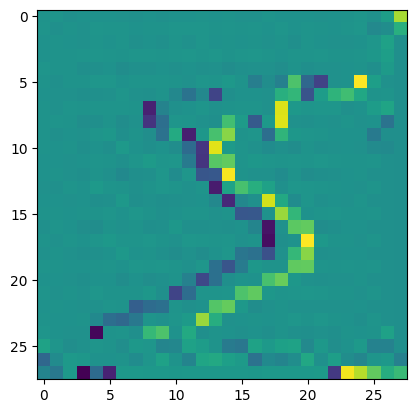

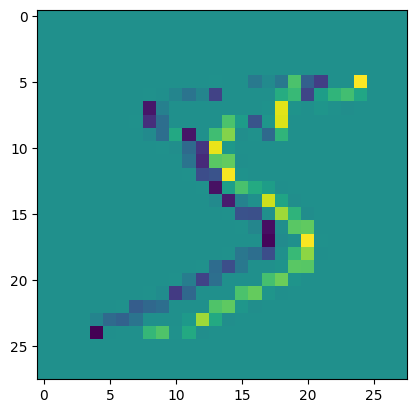

In [9]:
plt.imshow(s[:,:,0]) # we are now learning the right output!
plt.show()

plt.imshow(del_m.reshape(28, 28)) # so we can see that the score should look something like this after training
plt.show()

In [10]:
## for n = 0

# train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

# train_x_data = np.random.choice(x[:,:,0].ravel(),len(x[:,:,0].ravel()))
# train_y_data = np.random.choice(del_m,len(del_m))

# model.eval()
tqdm_len = tqdm.trange(1,N)

# model.cuda()
for n in tqdm_len:
  err = 1
  k = 0

  # initialize score function to noise
  s[:,:,n] = s[:,:,n-1] #s[:,:,n-1] # np.random.randn(*s[:,:,n-1].shape) # model(torch.tensor(scaler.fit_transform(m[:,:,n]).reshape(1,1,H*W))).cpu().reshape((H,W)).detach().numpy()
  del_sx[1:,:,n] = np.diff(s[:,:,n],axis=0)
  del_sx[0,:,n] = 0
  del_sy[:,1:,n] = np.diff(s[:,:,n],axis=1)
  del_sy[:,0,n] = 0

  while err > 1e-2:
    A = construct_A(dx,dy,dt,f[:,:,n],g[:,:,n],s[:,:,n],H,W)
    B = construct_B(dx,dy,dt,f[:,:,n],g[:,:,n],m[:,:,n-1],del_sx[:,:,n],del_sy[:,:,n],H,W)
    m[:,:,n] = solve_pde(A,B) # m is the transition log probability we solve using the KFP equation
    del_m = np.diff(m[:,:,n].ravel())
    del_m = np.insert(del_m,0,0)

    # if (n == 1 or n == N-1): # just look at first and last
    #   plt.imshow(del_m.reshape(H, W)) # we are now learning the right output!
    #   plt.show()

    #   plt.imshow(s[:,:,n]) # we are now learning the right output!
    #   plt.show()

    err = mean_squared_error(s[:,:,n].ravel(),del_m)

    # train_x_data, _, train_y_data, _ = train_test_split(x[:,:,0].ravel(), del_m, train_size=1.0, shuffle=True)

    # train_x_data = np.random.choice(scaler.fit_transform(x[:,:,n]).ravel(),len(x[:,:,0].ravel()))
    # train_y_data = np.random.choice(del_m,len(del_m))

    train_x_data = scaler.fit_transform(m[:,:,n]).ravel()
    train_y_data = del_m

    # loader = DataLoader(list(zip(train_x_data, train_y_data)), shuffle=True)
    model.train()
    # n_epochs = 100 # let's look for accuracy before looking at epochs
    # for epoch in range(n_epochs):
      # for X_batch, y_batch in loader:
    optimizer.zero_grad()
    y_pred = model(torch.tensor(train_x_data.reshape(1,1,H, W), requires_grad=True), n)
    loss = loss_fn(y_pred.ravel(), torch.tensor(train_y_data))
    
    loss.backward()
    optimizer.step()

    model.eval()
    s[:,:,n] = model(torch.tensor(scaler.fit_transform(m[:,:,n]).reshape(1,1,H, W)), n).cpu().reshape((H,W)).detach().numpy()
    del_sx[1:,:,n] = np.diff(s[:,:,n],axis=0)
    del_sx[0,:,n] = 0
    del_sy[:,1:,n] = np.diff(s[:,:,n],axis=1)
    del_sy[:,0,n] = 0

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [04:45<00:00,  2.88s/it]


# Integrate reverse time ODE

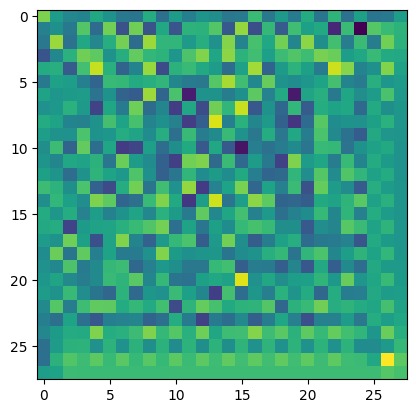

In [16]:
plt.imshow(s[:,:,1])
plt.show()

In [12]:
def ode_step(t, log_prob):
  diffusion_coeff = sigma ** (t*dt)
  
  model.eval()
  with torch.no_grad():
    score = model(torch.tensor(scaler.fit_transform(log_prob.reshape((H, W))).reshape(1,1,H, W)), t).detach().numpy()

  return -0.5 * diffusion_coeff**2 * score.reshape(1, H*W)

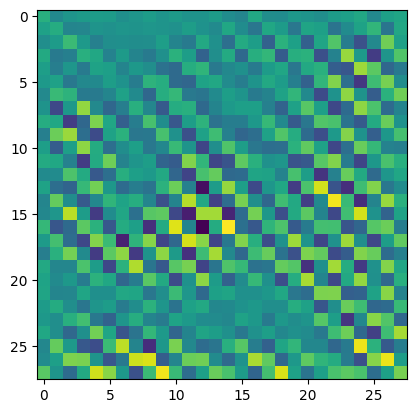

In [13]:
sample = kde.sample(H*W).reshape(-1) # np.exp(m[:, :, -1]).reshape(-1)

res = integrate.solve_ivp(ode_step, (100, 1), sample)

plt.imshow(res.y[:, -1].reshape(H, W));